In [1]:

def featureEngineeringDelay(df_train, df_test, df_airports):
    #adding arrival dalay
    fmt="%Y/%m/%d %H:%M:%S"
    fmt2="%H:%M:%S"
    ##############
    #to build dates on each flight stage
    #############
    # 1) add date to departure time
    #df_train=df_hdata
    df_train['DEPARTURE_DELAY'][df_train['DEPARTURE_DELAY'].isna()]=0
    df_train['SCHEDULED_DEPARTURE']=pd.to_datetime(df_train['SCHEDULED_DEPARTURE'], format=fmt)
    df_train['DEP_date_time']=df_train['SCHEDULED_DEPARTURE']+pd.to_timedelta(df_train['DEPARTURE_DELAY'],'m')
    # 2) arrival_time: DEP_date_time+ tax_out (min)+airtime (min)+tax_in (min)
    df_train['Arr_date_time']=df_train['DEP_date_time']+ pd.to_timedelta(df_train['TAXI_IN'],'m')+pd.to_timedelta(df_train['TAXI_OUT'],'m')+ pd.to_timedelta(df_train['AIR_TIME'],'m')
    #3)compute the date of schedule arrival: SCHEDULED_DEPARTURE+SCHEDULED_TIME (min)
    df_train['SCH_ARR_date_time']=pd.to_datetime(df_train['SCHEDULED_DEPARTURE'], format=fmt)+pd.to_timedelta(df_train['SCHEDULED_TIME'],'m')
    #4) compute arrival delay: schedule arrival-Arr_date_time
    df_train['arrival_delay']=(df_train['Arr_date_time']-df_train['SCH_ARR_date_time']).astype('timedelta64[m]')
    #5) for nan in AIR TIME -build wheels_on
    #5.1) compute wheels_on, wheels_off
    df_train['WHEELS_OFF']=df_train['DEP_date_time']+pd.to_timedelta(df_train['TAXI_OUT'],'m')
    df_train['WHEELS_ON']=df_train['Arr_date_time']-pd.to_timedelta(df_train['TAXI_IN'],'m')

    #prueb=df_train[df_train.WHEELS_ON.isnull()]

        
    #Merge Airports dataset to history df
    df_air_or = df_airports.rename(columns={'IATA_CODE':'ORIGIN_AIRPORT', 'CITY': 'OR_CITY', 'STATE': 'OR_STATE', 'COUNTRY': 'OR_COUNTRY', 'LATITUDE': 'OR_LATITUDE', 'LONGITUDE': 'OR_LONGITUDE'}, index={'ONE': 'Row_1'})
    df_air_des = df_airports.rename(columns={'IATA_CODE':'DESTINATION_AIRPORT', 'CITY': 'DES_CITY', 'STATE': 'DES_STATE', 'COUNTRY': 'DES_COUNTRY', 'LATITUDE': 'DES_LATITUDE', 'LONGITUDE': 'DES_LONGITUDE'}, index={'ONE': 'Row_1'})    
    df_final1 = df_train.merge(df_air_or, how='left', on='ORIGIN_AIRPORT', left_index=False, right_index=False, sort=False, suffixes=('_x', '_y'), copy=True, indicator=False, validate=None)
    df_final2 = df_final1.merge(df_air_des, how='left', on='DESTINATION_AIRPORT', left_index=False, right_index=False, sort=False, suffixes=('_x', '_y'), copy=True, indicator=False, validate=None)    
    df_final = df_final2.rename(columns={'AIRPORT_x':'OR_AIRPORT_NAME', 'AIRPORT_y': 'DES_AIRPORT_NAME'})

    #Merge Airports dataset to future data
    

    #adding date to SCHEDULED ARRIVAL INTO FUTURE DATA
    # if hour_de>hour_ar:
        #add 24H
        #else:
            #the same day
    
    #DATE TIME (HOUR, DAY, WEEKDAY,MONTH,YEAR)
    df_final['time_ar'] = df_final['SCH_ARR_date_time'].dt.time
    df_final['time_de'] = df_final['SCHEDULED_DEPARTURE'].dt.time
    df_final['year_de'] = df_final['SCHEDULED_DEPARTURE'].dt.year
    df_final['day_de'] = df_final['SCHEDULED_DEPARTURE'].dt.day
    df_final['weekday_de'] = df_final['SCHEDULED_DEPARTURE'].dt.weekday
    df_final['weekday_ar'] = df_final['SCH_ARR_date_time'].dt.weekday
    df_final['hour_de'] = df_final['SCHEDULED_DEPARTURE'].dt.hour
    df_final['hour_ar'] = df_final['SCH_ARR_date_time'].dt.hour

    #futere data dates
    df_test['SCHEDULED_ARRIVAL']=pd.to_datetime(df_test['SCHEDULED_ARRIVAL'], format=fmt2)
    df_test['SCHEDULED_DEPARTURE']=pd.to_datetime(df_test['SCHEDULED_DEPARTURE'])

    df_test['time_ar'] = df_test['SCHEDULED_ARRIVAL'].dt.time
    df_test['time_de'] = df_test['SCHEDULED_DEPARTURE'].dt.time
    df_test['year_de'] = df_test['SCHEDULED_DEPARTURE'].dt.year

    df_test['day_de'] = df_test['SCHEDULED_DEPARTURE'].dt.day
    df_test['weekday_de'] = df_test['SCHEDULED_DEPARTURE'].dt.weekday
    df_test['weekday_ar'] = df_test['SCHEDULED_ARRIVAL'].dt.weekday
    df_test['hour_de'] = df_test['SCHEDULED_DEPARTURE'].dt.hour
    df_test['hour_ar'] = df_test['SCHEDULED_ARRIVAL'].dt.hour

    
    #Approach as classification problem: "A flight os counted as "on time" if it operated less than 15 minutes later than the scheduled time shown in the carriers' Computerozed Researvation Systems (CRS)"
    
    # approach as classification problem 
    #df_train=df_hdata
    df_final['ARRIVAL_DELAY_15M'] = 0
    df_final['ARRIVAL_DELAY_15M'][df_final['arrival_delay'] > 15]=1
    
    df_final['DEPARTURE_DELAY_15M'] = 0
    df_final['DEPARTURE_DELAY_15M'][df_final['DEPARTURE_DELAY']> 15]=1
    

    #(expected/scheduled) speed    
    df_final['SPEED'] = df_final['DISTANCE']/df_final['SCHEDULED_TIME']    
    
    #drop cancelled cases
    df_final=df_final[df_final.CANCELLED==0]
    #drop varaibles
    #vars that take place after the schedule departure
    df_final.drop(columns=['DEPARTURE_TIME', 'SCHEDULED_ARRIVAL','ARRIVAL_TIME','SCHEDULED_DEPARTURE', 'TAXI_OUT', 'WHEELS_OFF', 'WHEELS_ON', 'TAXI_IN', 'DEP_date_time','Arr_date_time', 
                           'SCH_ARR_date_time', 'time_ar', 'time_de', 'hour_de', 'hour_ar','AIR_SYSTEM_DELAY', 'SECURITY_DELAY',
                           'AIRLINE_DELAY', 'LATE_AIRCRAFT_DELAY', 'WEATHER_DELAY','SCHEDULED_TIME', 'ELAPSED_TIME','AIR_TIME','CANCELLED', 'CANCELLATION_REASON'], inplace=True)
   
    # the numbers of flights on land and air on certain moment can play a role
    # number of fligths per airplane -tail number
    
    #TEMPORAL SOLUTION FOR THESE NAN
    df_final=df_final[df_final.arrival_delay.isna()==False]
    
    return(df_final,df_test)
    

def missingness(data):
    missingness_c = pd.DataFrame(np.column_stack([data.columns, data.isna().sum()]), columns=['Features', 'Missingness'])

    missingness_c['percentage'] = missingness_c.Missingness/len(data)

    return missingness_c

def encoders(x_train, x_test):
    # Handling with missing values
    # determine categorical and numerical features
    numerical = x_train.select_dtypes(include=['int64','float64']).columns
    categorical =x_train.select_dtypes(include=['object','bool']).columns
    print(f"Categorical columns are: {categorical}")
    print(f"Numerical columns are: {numerical}")

    #pipe for cat vars     
    cat_pipe = Pipeline([('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
                         ('encoder', OneHotEncoder(handle_unknown='ignore', sparse=False))])
    # Define value pipeline
    num_pipe = Pipeline([('imputer', SimpleImputer(strategy='median'))])

    #Combined classification pipeline and numerical pipeline
    preprocessor = ColumnTransformer(transformers=[('cat', cat_pipe, categorical),
                                                   ('num', num_pipe, numerical)])
    preprocessor.fit(x_train)
    x_train=preprocessor.transform(x_train)
    x_test=preprocessor.transform(x_test)
    print(f"x_train shape: {x_train.shape}")
    print(f"x_test shape: {x_test.shape}")

    return (x_train,x_test)

In [2]:
from sklearn import model_selection
from sklearn.linear_model import LinearRegression
from sklearn.datasets import fetch_openml
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import category_encoders as ce
from numpy import mean
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE,SMOTENC 
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, RobustScaler, QuantileTransformer
import category_encoders as ce
import  pandas as pd
import os
from sklearn.metrics import classification_report

df_airports = pd.read_csv('airports.csv')
df_hdata = pd.read_csv('historic_data.csv', low_memory=False).sample(frac=0.20)
df_future=pd.read_csv('future_data.csv', low_memory=False).sample(frac=0.50)
# preprocesing
feat_hd, feat_fd=featureEngineeringDelay(df_hdata,df_future,df_airports )


C:\Users\t3rma\AppData\Local\Temp\ipykernel_9116\691962594.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['DEPARTURE_DELAY'][df_train['DEPARTURE_DELAY'].isna()]=0
C:\Users\t3rma\AppData\Local\Temp\ipykernel_9116\691962594.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final['ARRIVAL_DELAY_15M'][df_final['arrival_delay'] > 15]=1
C:\Users\t3rma\AppData\Local\Temp\ipykernel_9116\691962594.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#return

In [3]:
#sample_df = feat_hd.sample(int(len(feat_hd) * 0.2))
#sample_df.shape
#feat_hd = sample_df 

In [4]:
feat_hd.drop(columns=['ARRIVAL_DELAY_15M', 'arrival_delay', 'DEPARTURE_DELAY','year_de'], inplace=True)
X_train, X_test= train_test_split(feat_hd, test_size=0.3, stratify=feat_hd.DEPARTURE_DELAY_15M)

y_train=X_train.DEPARTURE_DELAY_15M
y_test= X_test.DEPARTURE_DELAY_15M

X_train.drop(columns=['DEPARTURE_DELAY_15M'], inplace=True)
X_test.drop(columns=['DEPARTURE_DELAY_15M'], inplace=True)


# Create lists of numeric and categorical features  
numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X_train.select_dtypes(include=['object']).columns
cat_cols_index = X_train.columns.get_indexer(categorical_features )

# Create a numeric and categorical transformer to perform preprocessing steps
numeric_trans = Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                                  ('scaler', StandardScaler())])
categorical_trans= Pipeline(steps=[('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
                                   ('woe', ce.woe.WOEEncoder())])

# Use the ColumnTransformer to apply to the correct features
preprocessor= ColumnTransformer(
    transformers=[
        ('num', numeric_trans , numeric_features),
        ('cat', categorical_trans, categorical_features)])

preprocessor.fit(X_train, y_train)

X_train=preprocessor.transform(X_train)
X_test=preprocessor.transform(X_test)

k_values = [1, 2, 3, 4, 5, 6, 7]
for k in k_values:
    over = SMOTE(sampling_strategy=0.3, k_neighbors=k)
    under = RandomUnderSampler(sampling_strategy=0.5)
X, y = over.fit_resample(X_train, y_train)
X, y = under.fit_resample(X, y)


In [6]:
model = LogisticRegression(random_state=11, max_iter=1000)
model.fit(X, y) 
y_pred=model.predict(X_test)
print(classification_report(y_test, y_pred, zero_division=0))

              precision    recall  f1-score   support

           0       0.82      0.95      0.88    118176
           1       0.28      0.08      0.13     26910

    accuracy                           0.79    145086
   macro avg       0.55      0.52      0.51    145086
weighted avg       0.72      0.79      0.74    145086



In [7]:
from sklearn import ensemble,gaussian_process,linear_model,naive_bayes,neighbors,svm,tree

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from imblearn.ensemble import BalancedBaggingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import classification_report
from xgboost.sklearn import XGBClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import BaggingRegressor
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt   
import seaborn as sns

In [8]:
MLA = [
    #Ensemble Methods
    linear_model.LogisticRegression(),
    ensemble.AdaBoostRegressor(),
    ensemble.BaggingRegressor(),
    ensemble.ExtraTreesRegressor(),
    ensemble.GradientBoostingRegressor(),
    ensemble.RandomForestRegressor(n_jobs = -1),
    #Nearest Neighbor
    neighbors.KNeighborsRegressor(),
    #Trees    
    tree.DecisionTreeRegressor(),
    tree.ExtraTreeRegressor()
    ]

In [9]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve, roc_auc_score,precision_score,recall_score,auc

In [10]:
MLA_columns = []
MLA_compare = pd.DataFrame(columns = MLA_columns)
results=[]

row_index = 0
for alg in MLA:
    
    cv_results = cross_val_score(alg, X_train, y_train, cv=10)
    results.append(cv_results)
    predicted = alg.fit(X_train, y_train).predict(X_test)
    fp, tp, th = roc_curve(y_test, predicted)
    MLA_name = alg.__class__.__name__
    MLA_compare.loc[row_index,'MLA Name'] = MLA_name
    MLA_compare.loc[row_index, 'MLA Train Accuracy'] = round(alg.score(X_train, y_train), 4)
    MLA_compare.loc[row_index, 'MLA Test Accuracy'] = round(alg.score(X_test, y_test), 4)
    MLA_compare.loc[row_index, 'MLA AUC'] = auc(fp, tp)
    
    
    row_index+=1
    
MLA_compare.sort_values(by = ['MLA Test Accuracy'], ascending = False, inplace = True)    
MLA_compare

C:\Users\t3rma\venv\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\t3rma\venv\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check

,MLA Name,MLA Train Accuracy,MLA Test Accuracy,MLA AUC
0,LogisticRegression,0.8147,0.8143,0.500393
4,GradientBoostingRegressor,0.0485,0.0222,0.611263
1,AdaBoostRegressor,0.0309,0.0074,0.578369
5,RandomForestRegressor,0.8611,-0.0143,0.602024
3,ExtraTreesRegressor,1.0000,-0.0549,0.594751
2,BaggingRegressor,0.8078,-0.1018,0.574534
6,KNeighborsRegressor,0.2475,-0.1401,0.561968
7,DecisionTreeRegressor,1.0000,-0.9653,0.527787
8,ExtraTreeRegressor,1.0000,-0.9954,0.523785


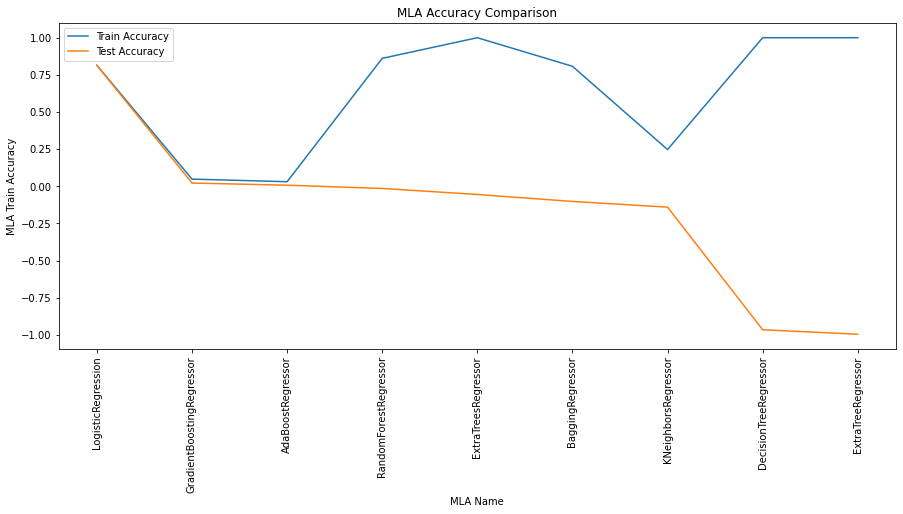

In [11]:
plt.subplots(figsize=(15,6))
sns.lineplot(x="MLA Name", y="MLA Train Accuracy",data=MLA_compare,palette='hot',label='Train Accuracy')
sns.lineplot(x="MLA Name", y="MLA Test Accuracy",data=MLA_compare,palette='hot',label='Test Accuracy')
plt.xticks(rotation=90)
plt.title('MLA Accuracy Comparison')
plt.legend()
plt.show()

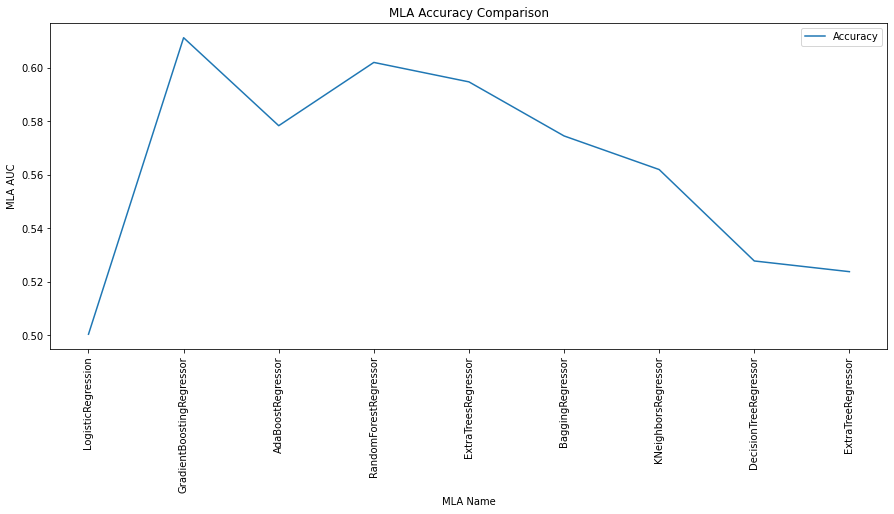

In [12]:
plt.subplots(figsize=(15,6))
sns.lineplot(x="MLA Name", y="MLA AUC",data=MLA_compare,palette='hot',label='Accuracy')

plt.xticks(rotation=90)
plt.title('MLA Accuracy Comparison')
plt.legend()
plt.show()

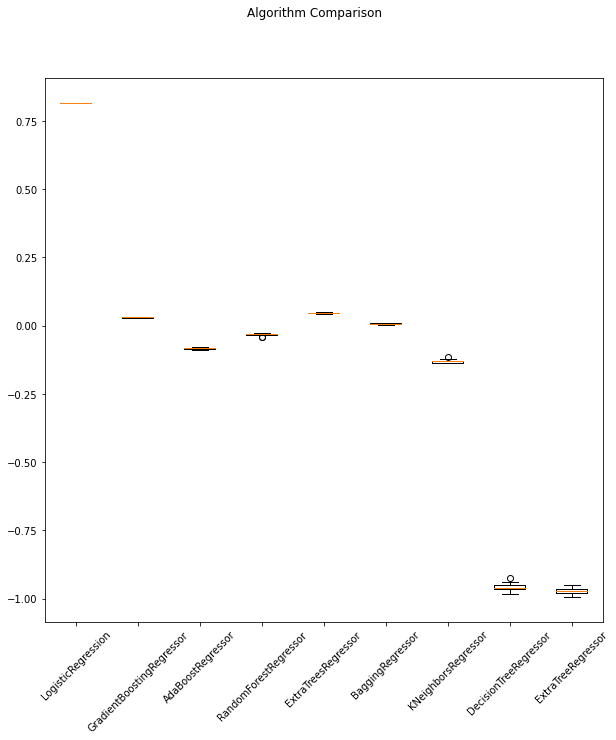

In [13]:
#sns.boxplot(MLA_compare["MLA AUC"])# boxplot algorithm comparison
fig = plt.figure(figsize=(10,10))
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results,labels=MLA_compare['MLA Name'])
plt.xticks(rotation=45)
plt.show()

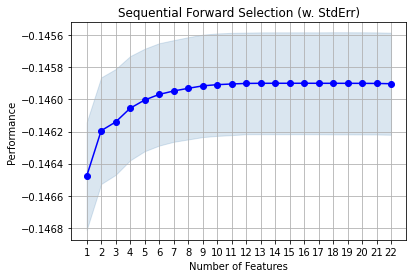

In [14]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
sfs = SFS(lr, k_features='best', forward=True, floating=False, 
          scoring='neg_mean_squared_error', cv=10)
model = sfs.fit(X_train, y_train)

fig = plot_sfs(sfs.get_metric_dict(), kind='std_err')

plt.title('Sequential Forward Selection (w. StdErr)')
plt.grid()
plt.show()

In [15]:
print('Selected features:', sfs.k_feature_idx_)

Selected features: (2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 20)


In [16]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
forest_model = RandomForestRegressor(n_estimators = 100, random_state=42)

In [17]:
forest_model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [18]:
# Predict the target based on testdata 
flightdelay_pred= forest_model.predict(X_test)

In [19]:
import numpy as np
#Calculate the absolute errors
errors_random1 = abs(flightdelay_pred - y_test)
print('Mean Absolute Error: ', round(np.mean(errors_random1),3), 'minutes.')

Mean Absolute Error:  0.302 minutes.


In [20]:
print("----------------- TRAINING ------------------------")
print("r-squared score: ",forest_model.score(X_train, y_train))
print("------------------- TEST --------------------------")
print("r-squared score: ", forest_model.score(X_test, y_test))

----------------- TRAINING ------------------------
r-squared score:  0.8613131917706067
------------------- TEST --------------------------
r-squared score:  -0.013183330444193508
